# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Section 4: Natural Language Processing


**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner <br/>
**Authors**: Shivas Jayaram 


<hr style="height:2pt">

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Objectives

By the end of this section, you should be able to:
* Perform preprocessing operation on text
* Perform text classification task using various model architectures
* Following a structured approach to model training and comparing results
  * Save model weights, architecture, training params, metrics, & training history
* Familiarize with SOTA(State Of The Art) pretrained language models and hot to use them for your custom dataset:
  * Glove pre trained embeddings
  * BERT(Bidirectional Encoder Representations from Transformers) for text classification tasks
  * GPT2(Generative Pre-Training) for language generation tasks
* Create your own Word2Vec embeddings

<a id="contents"></a>

## Notebook Contents
- [**Preprocessing Text Data Recap**](#prep)
    - [Text processing using NLTK](#prep) 
- [**Text Classification**](#textclass)
    - [Overview](#333) 
    - [Fully Connected Networks](#333)
    - [Conv1D (with/without pretrained embeddings)](#333)
    - [Pretrained BERT](#333)
- [**Text Generation using GPT2**](#gpt2)
    - [Overview](#gpt2_overview) 
    - [Pretrained GPT2](#gpt2_pretrained)
    - [Break Out Room 🎊🎉](#breakout)
    - [Finetune GPT2](#gpt2_finetune)
- [**Word Embeddings (Word2Vec)**](#word2vec)
    - [Overview](#word2vec_overview) 
    - [Generate Training Data](#word2vec_data) 
    - [Build Word2Vec](#word2vec_model)
    - [Traning Word2Vec Molel](#word2vec_train)
    - [Analyze Embeddings](#word2vec_analyze)
- [**References**](#references)


## **Setup Notebook**

**Installs**

We will install Huggingface’s transformers library. This library let us import a wide range of transformer-based pre-trained models. In our case, we will use GPT2 & BERT.

In [2]:
# Installation for Google Colab
!pip install transformers==4.4.1

# Installation for Jupyter Hub
# !sudo /usr/share/anaconda3/bin/conda install -c huggingface transformers==4.4.1 -y

     |████████████████████████████████| 2.1MB 9.1MB/s 
     |████████████████████████████████| 890kB 37.9MB/s 
     |████████████████████████████████| 3.2MB 56.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=d2499550acbe70695b9229a608881e2a730d4b13cd6c7323e967ca8fdf53f9da
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


**Imports**

In [3]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import string
import re
import numpy as np
import pandas as pd
from glob import glob
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# NLTK
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.metrics.pairwise import cosine_similarity

# Transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel, GPT2Config

In [4]:
# download nltk's punkt sentence tokenizer
nltk.download('punkt')
# download nltk's stop words
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Verify Setup**

In [5]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.4.1
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Utils**

Here we define some helper functions that would be used in loading data, saving models and evaluating models.

In [6]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

def save_model(model, path="models",model_name="model01"):

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)

  if isinstance(model,TFBertForSequenceClassification):
    #model.save_pretrained(path)
    model.save_weights(os.path.join(path,model_name+".h5"))
  else:
    # Save the enitire model (structure + weights)
    model.save(os.path.join(path,model_name+".hdf5"))

    # Save only the weights
    model.save_weights(os.path.join(path,model_name+".h5"))

    # Save the structure only
    model_json = model.to_json()
    with open(os.path.join(path,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(path="models",model_name="model01"):
  model_size = os.stat(os.path.join(path,model_name+".h5")).st_size
  return model_size

def evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, epochs,save=True):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(20,5))
  axs = fig.add_subplot(1,3,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,3,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
      # Save model
      save_model(model, model_name=model.name)
      model_size = get_model_size(model_name=model.name)

      # Save model history
      with open(os.path.join("models",model.name+"_train_history.json"), "w") as json_file:
          json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

      trainable_parameters = count_params(model.trainable_weights)
      non_trainable_parameters = count_params(model.non_trainable_weights)

      # Save model metrics
      metrics ={
          "trainable_parameters":trainable_parameters,
          "execution_time":execution_time,
          "loss":evaluation_results[0],
          "accuracy":evaluation_results[1],
          "model_size":model_size,
          "learning_rate":learning_rate,
          "epochs":epochs,
          "name": model.name,
          "id": int(time.time())
      }
      with open(os.path.join("models",model.name+"_metrics.json"), "w") as json_file:
          json_file.write(json.dumps(metrics,cls=JsonEncoder))

## **Preprocessing Text Data** <div id='prep'>

#### **Review**

**Basic Definitions:**
- Natural Language Processing (NLP): The use of computers to process linguistic information into structured data and extract useful insights
- Document: A single unit of observation used in NLP, which could be as short as a word or as long as a book
- Corpus: A collection of documents from a shared context that are processed and analyzed using NLP

**Conceptual:**
- Text is structured data, but lacks the simple structure needed for quantitative analysis and ML
- Extensive preprocessing and parsing is needed to convert plain text into structured data
- How to parse a given document depends upon the specific application and the corpus being used
- Once parsed, documents can be analyzed like other quantitative datasets 


**Common NLP Tools:**
- [<font color="green">Natural Language Toolkit</font>](https://www.nltk.org)
- [scikit-learn](https://scikit-learn.org)
- [CoreNLP](https://stanfordnlp.github.io/CoreNLP/)
- [Gensim](https://radimrehurek.com/gensim/)
- [spaCy](https://spacy.io/)
- [AllenNLP](https://allennlp.org/)
- [<font color="green">Transformers</font>](https://huggingface.co/transformers/index.html)

**Basic Data Pipeline for NLP:**
- <font color="green">Data ingestion from files, scraping, APIs</font>
- <font color="green">Removing stop words</font>
- Word stemming and lemmatization
- <font color="green">Parsing text using regular expressions</font>
- <font color="green">Tokenizing / Text Vectorization</font>
- Creating a “bag of words” model
- Creating TF-IDF vectors
- <font color="green">Creating word embeddings</font>

#### **Preprocessing using NLTK**

In [7]:
input_text = """Advanced Topics in Data Science (CS109b) is the second half of a one-year introduction to data science. 
Building upon the material in Introduction to Data Science, the course introduces advanced methods for data wrangling, 
data visualization, statistical modeling, and prediction. Topics include big data, multiple deep learning architectures 
such as CNNs, RNNs, transformers, language models, autoencoders, and generative models as well as basic Bayesian methods, 
nonlinear statistical models, and unsupervised learning.
"""

In [8]:
# Get sentences
sentences = sent_tokenize(input_text)
print("Sentences:")
for sentence in sentences:
  print(sentence)

# Get words
words = word_tokenize(input_text)
print("\nWords:")
print(words)

# Number of words
print("\n Number of Words:", len(words))

Sentences:
Advanced Topics in Data Science (CS109b) is the second half of a one-year introduction to data science.
Building upon the material in Introduction to Data Science, the course introduces advanced methods for data wrangling, 
data visualization, statistical modeling, and prediction.
Topics include big data, multiple deep learning architectures 
such as CNNs, RNNs, transformers, language models, autoencoders, and generative models as well as basic Bayesian methods, 
nonlinear statistical models, and unsupervised learning.

Words:
['Advanced', 'Topics', 'in', 'Data', 'Science', '(', 'CS109b', ')', 'is', 'the', 'second', 'half', 'of', 'a', 'one-year', 'introduction', 'to', 'data', 'science', '.', 'Building', 'upon', 'the', 'material', 'in', 'Introduction', 'to', 'Data', 'Science', ',', 'the', 'course', 'introduces', 'advanced', 'methods', 'for', 'data', 'wrangling', ',', 'data', 'visualization', ',', 'statistical', 'modeling', ',', 'and', 'prediction', '.', 'Topics', 'include', '

In [9]:
# Get Word tokenizer from NLTK
tokenizer = RegexpTokenizer(r'\w+')

# Word Tokenize text
words = tokenizer.tokenize(input_text)
print("Words:")
print(words)

# Number of words
print("\n Number of Words:", len(words))

Words:
['Advanced', 'Topics', 'in', 'Data', 'Science', 'CS109b', 'is', 'the', 'second', 'half', 'of', 'a', 'one', 'year', 'introduction', 'to', 'data', 'science', 'Building', 'upon', 'the', 'material', 'in', 'Introduction', 'to', 'Data', 'Science', 'the', 'course', 'introduces', 'advanced', 'methods', 'for', 'data', 'wrangling', 'data', 'visualization', 'statistical', 'modeling', 'and', 'prediction', 'Topics', 'include', 'big', 'data', 'multiple', 'deep', 'learning', 'architectures', 'such', 'as', 'CNNs', 'RNNs', 'transformers', 'language', 'models', 'autoencoders', 'and', 'generative', 'models', 'as', 'well', 'as', 'basic', 'Bayesian', 'methods', 'nonlinear', 'statistical', 'models', 'and', 'unsupervised', 'learning']

 Number of Words: 72


In [10]:
# Remove stop words
stop_words = set(stopwords.words('english')) 

# Words
words = tokenizer.tokenize(input_text)

# Remove stop words
words = [w.lower() for w in words if w.lower() not in stop_words]
print("Words:")
print(words)

# Number of words
print("\nNumber of Words:", len(words))

# Number of unique words
num_unique_words = set(words)
print("Number of unique words (Vocabulary size):",len(num_unique_words))

print("\nVocabulary:",num_unique_words)

Words:
['advanced', 'topics', 'data', 'science', 'cs109b', 'second', 'half', 'one', 'year', 'introduction', 'data', 'science', 'building', 'upon', 'material', 'introduction', 'data', 'science', 'course', 'introduces', 'advanced', 'methods', 'data', 'wrangling', 'data', 'visualization', 'statistical', 'modeling', 'prediction', 'topics', 'include', 'big', 'data', 'multiple', 'deep', 'learning', 'architectures', 'cnns', 'rnns', 'transformers', 'language', 'models', 'autoencoders', 'generative', 'models', 'well', 'basic', 'bayesian', 'methods', 'nonlinear', 'statistical', 'models', 'unsupervised', 'learning']

Number of Words: 54
Number of unique words (Vocabulary size): 39

Vocabulary: {'modeling', 'generative', 'topics', 'year', 'wrangling', 'material', 'building', 'course', 'one', 'deep', 'architectures', 'well', 'science', 'transformers', 'bayesian', 'learning', 'rnns', 'prediction', 'big', 'methods', 'unsupervised', 'cs109b', 'multiple', 'visualization', 'autoencoders', 'introduces', 

#### **Text Vectorization using tf.keras**

In [11]:
# Words
words = tokenizer.tokenize(input_text)
num_unique_words = set(words)

# Initialize Text Vectorizer
text_vectorizer = TextVectorization(
    max_tokens=len(num_unique_words)+2,
    output_mode="int"
)


# Generate Text Vector
text_vectorizer.adapt(words)

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)

# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))

print("vocabulary:",len(vocabulary),vocabulary)
print("word_index:",word_index)

print("\nExample:",text_vectorizer("data science is awesome"))
print("\nExample:",text_vectorizer("I like ice cream"))

Vocabulary Size: 51
vocabulary: 51 ['', '[UNK]', 'data', 'the', 'science', 'models', 'as', 'and', 'topics', 'to', 'statistical', 'methods', 'learning', 'introduction', 'in', 'advanced', 'year', 'wrangling', 'well', 'visualization', 'upon', 'unsupervised', 'transformers', 'such', 'second', 'rnns', 'prediction', 'one', 'of', 'nonlinear', 'multiple', 'modeling', 'material', 'language', 'is', 'introduces', 'include', 'half', 'generative', 'for', 'deep', 'cs109b', 'course', 'cnns', 'building', 'big', 'bayesian', 'basic', 'autoencoders', 'architectures', 'a']
word_index: {'': 0, '[UNK]': 1, 'data': 2, 'the': 3, 'science': 4, 'models': 5, 'as': 6, 'and': 7, 'topics': 8, 'to': 9, 'statistical': 10, 'methods': 11, 'learning': 12, 'introduction': 13, 'in': 14, 'advanced': 15, 'year': 16, 'wrangling': 17, 'well': 18, 'visualization': 19, 'upon': 20, 'unsupervised': 21, 'transformers': 22, 'such': 23, 'second': 24, 'rnns': 25, 'prediction': 26, 'one': 27, 'of': 28, 'nonlinear': 29, 'multiple': 30,

---

## **Text Classification** <div id='textclass'>
---

### **Overview**

In this section, we're going to be working with news articles from CNN. We will explore the dataset, prepare the data for modeling, and try different models, which includes simple networks, networks with embeddings, networks with pretrained embeddings and BERT.

**The Task:** Classify news articles into three categories, namely politics, health, and entertainment.

### **Dataset**

The dataset consists of news articles pulled from CNN in the politics, health, and entertainment categories. There are about 300 articles in each category. 

#### **Download**

Download the datasets to colab.

In [12]:
start_time = time.time()
# Dowload the news dataset
download_file("https://storage.googleapis.com/cs109b/datasets/news300.zip", base_path="datasets", extract=True)
# Download Glove pretrained embeddings
download_file("https://github.com/shivasj/dataset-store/releases/download/v3.0/glove.6B.100d.txt.zip", 
              base_path="embedding", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.11693284511566163


#### **Load Data**

* Read-in data as lists.
* Each element in data_x is the content of a sample, namely an news article. 
* Each element in data_y is the label of that article.

In [13]:
data_dir = os.path.join("datasets","news300")
label_names = os.listdir(data_dir)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

# Generate a list of labels and path to text
data_x = []
data_y = []

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir,label))
  data_x.extend([os.path.join(data_dir,label,f) for f in text_files])
  data_y.extend([label for f in text_files])

# Load the text content
for idx, path in enumerate(data_x):
  # Load text
  with open(path) as file:
    data_x[idx] = file.read()

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print("Label counts:",np.unique(data_y, return_counts=True))

Number of classes: 3
Labels: ['entertainment', 'health', 'politics']
data_x count: 920
data_y count: 920
Label counts: (array(['entertainment', 'health', 'politics'], dtype='<U13'), array([310, 310, 300]))


#### **View Text**

Let's take a look at the data.

In [14]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(data_x)-1, size=10)
for i,data_idx in enumerate(data_samples):
  print("Label:",data_y[data_idx],", Text:",data_x[data_idx])

Label: health , Text: Dr. Sanjay Gupta's coronavirus podcast for March 25: Searching for treatments  (CNN) Currently there is no proven treatment or cure for Covid-19, but scientists around the globe are working to find one. In today's edition of "Coronavirus: Fact vs. Fiction," CNN Chief Medical Correspondent Dr. Sanjay Gupta explains some of the drug names floating around and what we know about them.  You can listen on your favorite podcast app or read the transcript below: President Donald Trump: So chloroquine or hydroxychloroquine. Now, this is a common malaria drug. Dr. Sanjay Gupta: That was President Trump last Thursday.  Maybe you've been watching the White House briefings and heard from the president that an old drug is being repurposed as an experimental treatment for Covid-19.   Trump: And it's shown very encouraging — very, very encouraging early results.  And we're going to be able to make that drug available almost immediately.   Dr. Gupta: Last Friday, a reporter asked 

#### **Split Data** 
We split data into train and validation by randomly selecting 20% as the validation set.

In [15]:
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 736
validate_x count: 184


### **Build Data Pipelines**

#### **Text Vectorization**

[Reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization)

Since machines cannot read text directly, we need to transform text into numerical vectors. Here is a common procedure of generating Text Vectors.
- Standardize each sample (usually lowercasing + punctuation stripping)
- Split each sample into substrings (usually words)
- Recombine substrings into tokens (usually ngrams)
- Index tokens (associate a unique int value with each token)
- Transform each sample using this index, either into a vector of ints or a dense float vector

In [16]:
# Text Vectorization
def standardize_text(input_text):
  # Convert to lowercase
  lowercase = tf.strings.lower(input_text)
  # Remove HTML tags
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
  return tf.strings.regex_replace(
      stripped_html, "[%s]" % re.escape(string.punctuation), ""
  )

In [17]:
# Define parameters for TextVectorization
# max_token controls the vocabulary size based on frequency
# output_sequence_length controls the length of each vector. If set, 
# the initial vector would be padded or truncated to match the specified length.

max_features = 15000
sequence_length = 1000

# Initialize Text Vectorizer
text_vectorizer = TextVectorization(
    standardize=standardize_text,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Create the vocabulary of entire dataset
text_data = tf.data.Dataset.from_tensor_slices(data_x)

# Generate Text Vector
start_time = time.time()
text_vectorizer.adapt(text_data.batch(64))
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)
# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))

Execution time (mins) 0.007613853613535563
Vocabulary Size: 15000


In [18]:
# Check Vocabulary : 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens
print("Vocabulary:",vocabulary[:20])
print("Vocabulary Size:",len(vocabulary))

Vocabulary: ['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'in', 'that', 'for', 'is', 'on', 'said', 'with', 'as', 'it', 'have', 'are', 'be', 'at']
Vocabulary Size: 15000


In [19]:
# Test our text vectorizer
test_text = data_x[data_samples[0]]
print(test_text)
test_text_vector = text_vectorizer([test_text])
print("Shape:",test_text_vector.shape)
# display only the first 20 tokens of the sample 0
print(test_text_vector[0,:20])

Dr. Sanjay Gupta's coronavirus podcast for March 25: Searching for treatments  (CNN) Currently there is no proven treatment or cure for Covid-19, but scientists around the globe are working to find one. In today's edition of "Coronavirus: Fact vs. Fiction," CNN Chief Medical Correspondent Dr. Sanjay Gupta explains some of the drug names floating around and what we know about them.  You can listen on your favorite podcast app or read the transcript below: President Donald Trump: So chloroquine or hydroxychloroquine. Now, this is a common malaria drug. Dr. Sanjay Gupta: That was President Trump last Thursday.  Maybe you've been watching the White House briefings and heard from the president that an old drug is being repurposed as an experimental treatment for Covid-19.   Trump: And it's shown very encouraging — very, very encouraging early results.  And we're going to be able to make that drug available almost immediately.   Dr. Gupta: Last Friday, a reporter asked coronavirus task force

#### **Create TF Datasets**

In [20]:
BATCH_SIZE = 32
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')

# Vectorize Text
def vectorize_text(text, label=None):
  text = tf.expand_dims(text, -1)
  text = text_vectorizer(text)
  if label is None:
    return text
  else:
    return text, label

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, 1000), (None, 3)), types: (tf.int64, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 1000), (None, 3)), types: (tf.int64, tf.float32)>


### **Text Classificaton Models**

#### **Simple Fully Connected Network**

* We will start with a simple fully connected neural network. 
* In this model, each layer is a dense layer
* Wer use activation function in  the hidden layers as ReLU. 
* Since our task is a multiclass classification problem, we use softmax as the activation function in the output layer.

##### Build Model

In [21]:
def build_simple_fcn(num_classes, sequence_length):
  # Set the model name as
  model_name = 'simple_fcn_'+str(int(time.time()))

  # Model input
  model_input = keras.layers.Input(shape=(sequence_length))

  hidden = keras.layers.Dense(1024, activation="relu")(model_input)
  hidden = keras.layers.Dense(1024, activation="relu")(hidden)
  hidden = keras.layers.Dense(512, activation="relu")(hidden)
  hidden = keras.layers.Dense(512, activation="relu")(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(inputs=model_input, outputs=output, name=model_name)

  return model

##### Train

Model: "simple_fcn_1616760408"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1025024   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 2,863,619
Trainable params: 2,863,619
Non-trainable params: 0
___________________________________

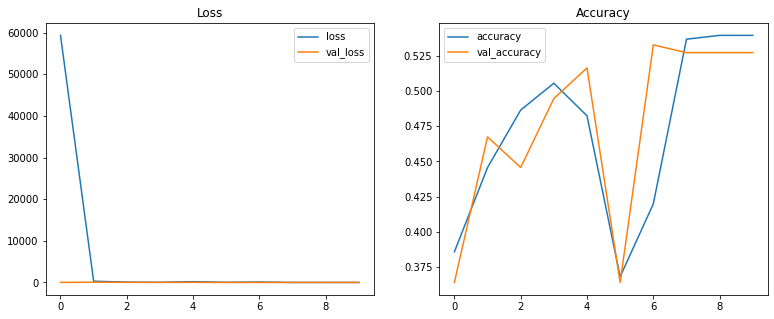

6/6 [==============================] - 0s 4ms/step - loss: 1.0237 - accuracy: 0.5272
[1.0237090587615967, 0.5271739363670349]


In [22]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_simple_fcn(num_classes, sequence_length)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model, validation_data, training_results, execution_time, learning_rate, epochs)

#### **Simple Fully Connected Network with Embedding**

* Let's add an embedding layer to the previous simple fully connected network

##### Build Model

In [23]:
def build_simple_fcn_with_emb(num_classes,sequence_length, vocab_size, embedding_dim):
  # Set the model name as
  model_name = 'simple_fcn_emb'+str(int(time.time()))

  # Model input
  model_input = keras.layers.Input(shape=(sequence_length))

  hidden = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(model_input)
  hidden = keras.layers.Flatten()(hidden)
  hidden = keras.layers.Dense(1024, activation="relu")(hidden)
  hidden = keras.layers.Dense(512, activation="relu")(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(inputs=model_input, outputs=output, name=model_name)

  return model

##### Train

Model: "simple_fcn_emb1616760413"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         1500000   
_________________________________________________________________
flatten (Flatten)            (None, 100000)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102401024 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 104,427,363
Trainable params: 104,427,363
Non-trainable params: 0
____________________________

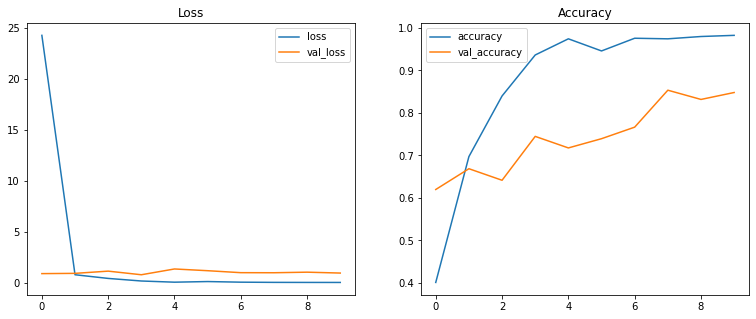

6/6 [==============================] - 0s 9ms/step - loss: 0.9574 - accuracy: 0.8478
[0.9574431777000427, 0.8478260636329651]


In [24]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10
embedding_dim = 100

# Free up memory
K.clear_session()

# Build the model
model = build_simple_fcn_with_emb(num_classes, sequence_length, vocabulary_size,embedding_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model, validation_data, training_results, execution_time, learning_rate, epochs)

#### **Conv1D Network with Embedding**

* Next let us use Conv1D layers to build the model

##### Build Model

In [25]:
def build_conv1d_emb(num_classes,sequence_length, vocab_size, embedding_dim):
  # Set the model name as
  model_name = 'conv1d_emb_'+str(int(time.time()))

  # Model input
  model_input = keras.layers.Input(shape=(sequence_length))

  # Embedding Layer
  hidden = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding")(model_input)

  # Conv1D + Global Max Pooling
  hidden = keras.layers.Conv1D(filters=256, kernel_size=5, padding="valid", activation="relu", strides=3)(hidden)
  hidden = keras.layers.GlobalMaxPooling1D()(hidden)

  # Dense Layer
  hidden = keras.layers.Dense(units=128, activation="relu")(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(inputs=model_input, outputs=output, name=model_name)

  return model

##### Train

Model: "conv1d_emb_1616760431"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         1500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 332, 256)          128256    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,661,539
Trainable params: 1,661,539
Non-trainable params: 0
___________________________________

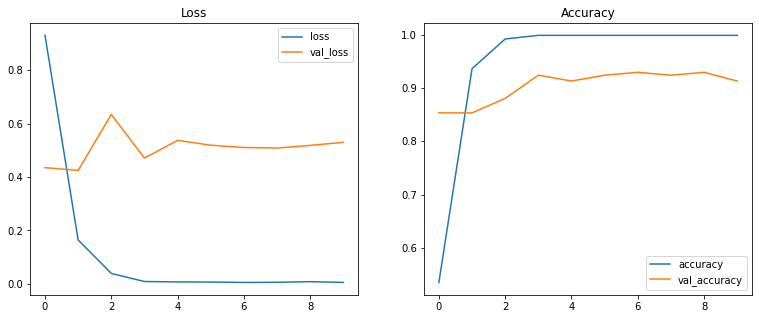

6/6 [==============================] - 0s 7ms/step - loss: 0.5298 - accuracy: 0.9130
[0.52984619140625, 0.9130434989929199]


In [26]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10
embedding_dim = 100

# Free up memory
K.clear_session()

# Build the model
model = build_conv1d_emb(num_classes, sequence_length, vocabulary_size,embedding_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model, validation_data, training_results, execution_time, learning_rate, epochs)

#### **Conv1D Network with pretrained Embedding**

* Alternatively, we could initialize embeddings with pre-trained word embeddings.
* Specifically, let's try GloVe embeddings. GloVe stands for Global Vectors, which is an open-source project developed by Stanford. It contains pre-trained word representations in various sizes, including 50-dimensional, 100-dimensional, 200-dimensional, and 300-dimensional.

* In this model, we choose the 100d version.

[Reference](http://nlp.stanford.edu/projects/glove/)

##### Prepare Embedding

We need to prepare the pretrained embedding to use in our model

In [27]:
EMBEDDING_FILE = os.path.join("embedding","glove.6B.100d.txt")

embeddings_index = {}
with open(EMBEDDING_FILE) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Number of word vectors:",len(embeddings_index))

Number of word vectors: 400000


In [28]:
# View some word embeddings
sample_embeddings_words = list(embeddings_index.keys())[:10]
for word in sample_embeddings_words:
  print(word,":",embeddings_index[word][:5],", Shape:", embeddings_index[word].shape)

the : [-0.038194 -0.24487   0.72812  -0.39961   0.083172] , Shape: (100,)
, : [-0.10767  0.11053  0.59812 -0.54361  0.67396] , Shape: (100,)
. : [-0.33979  0.20941  0.46348 -0.64792 -0.38377] , Shape: (100,)
of : [-0.1529  -0.24279  0.89837  0.16996  0.53516] , Shape: (100,)
to : [-0.1897    0.050024  0.19084  -0.049184 -0.089737] , Shape: (100,)
and : [-0.071953  0.23127   0.023731 -0.50638   0.33923 ] , Shape: (100,)
in : [ 0.085703 -0.22201   0.16569   0.13373   0.38239 ] , Shape: (100,)
a : [-0.27086   0.044006 -0.02026  -0.17395   0.6444  ] , Shape: (100,)
" : [-0.30457 -0.23645  0.17576 -0.72854 -0.28343] , Shape: (100,)
's : [ 0.58854 -0.2025   0.73479 -0.68338 -0.19675] , Shape: (100,)


In [29]:
# Prepare embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_features, embedding_dim))
oov = {}    
n_covered = 0
n_oov = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    else:
      n_oov += 1

text_coverage = (vocabulary_size-n_oov)/vocabulary_size
print("Text Coverage:",text_coverage)

print("Embedding Matrix, Shape" ,embedding_matrix.shape)

Text Coverage: 0.9396
Embedding Matrix, Shape (15000, 100)


In [71]:
# Test oov
print(embeddings_index.get('covid'))

None


##### Build Model

In [30]:
def build_conv1d_pretrained_emb(num_classes,sequence_length, vocab_size, embedding_dim):
  # Set the model name as
  model_name = 'conv1d_pretrained_emb_'+str(int(time.time()))

  # Model input
  model_input = keras.layers.Input(shape=(sequence_length))

  # Embedding Layer, with pre-trained weights
  hidden = keras.layers.Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Load pre-trained weights
                            trainable=False, # Set Trainable to False
                            name="embedding")(model_input)

  # Conv1D + Global Max Pooling
  hidden = keras.layers.Conv1D(filters=256, kernel_size=5, padding="valid", activation="relu", strides=3)(hidden)
  hidden = keras.layers.GlobalMaxPooling1D()(hidden)

  # Dense Layer
  hidden = keras.layers.Dense(units=128, activation="relu")(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(inputs=model_input, outputs=output, name=model_name)

  return model

##### Train

Model: "conv1d_pretrained_emb_1616760461"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         1500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 332, 256)          128256    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,661,539
Trainable params: 161,539
Non-trainable params: 1,500,000
__________________

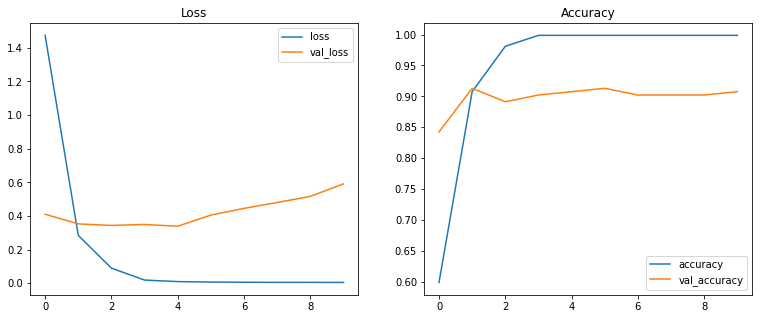

6/6 [==============================] - 0s 7ms/step - loss: 0.5910 - accuracy: 0.9076
[0.5909943580627441, 0.907608687877655]


In [31]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10
embedding_dim = 100

# Free up memory
K.clear_session()

# Build the model
model = build_conv1d_pretrained_emb(num_classes, sequence_length, vocabulary_size,embedding_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model, validation_data, training_results, execution_time, learning_rate, epochs)

### **Text Classification using BERT**



#### **Build Data Pipelines**



##### Text Tokenization ([Reference](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer))

In [32]:
# Tokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

* Let's see two examples of tokenization. We could encode a single sentence with encode_plus, or we could tokenize multiple sentences at the same time with batch_encode_plus.

In [33]:
# Tokenizer encode_plus
text = "What you need to know about using them safely amid the pandemic"
outputs = tokenizer.encode_plus(text, 
                  add_special_tokens = True, # add [CLS], [SEP]
                  max_length = 15, # max length of the text that can go to BERT (<=512)
                  padding='max_length',
                  return_attention_mask = True, # add attention mask to not focus on pad tokens
                  truncation='longest_first',
                  return_tensors="tf"
              )
print("Tokenizer Output:",outputs)

# Tokenizer batch_encode_plus
text = ["What you need to know about using them safely amid the pandemic", 
        "A third of Medicare enrollees with coronavirus ended up in the hospital"]
outputs = tokenizer.batch_encode_plus(text, 
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        truncation='longest_first',
        max_length=15
      )
print("Tokenizer Output:",outputs)

Tokenizer Output: {'input_ids': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=
array([[  101,  2054,  2017,  2342,  2000,  2113,  2055,  2478,  2068,
         9689, 13463,  1996,  6090,  3207,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
Tokenizer Output: {'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[  101,  2054,  2017,  2342,  2000,  2113,  2055,  2478,  2068,
         9689, 13463,  1996,  6090,  3207,   102],
       [  101,  1037,  2353,  1997, 27615, 25612, 10285,  2007, 21887,
        23350,  3092,  2039,  1999,  1996,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dt

* Input ids: are the only required parameters to be passed to the model as input. They are token indices, numerical representations of tokens building the sequences that will be used as input by the model.
* Attention mask: is an optional argument used when batching sequences together. This argument indicates to the model which tokens should be attended to, and which should not.
* Token type ids: Some models’ purpose is to do sequence classification or question answering. These require two different sequences to be joined in a single “input_ids” entry, which usually is performed with the help of special tokens, such as the classifier ([CLS]) and separator ([SEP]) tokens. For example, the BERT model builds its two sequence input as such:

* Here, we will tokenize news articles. To setup for BERT, we need to add special tokens,  namely [CLS] at the beginning and [SEP] at the end of each sentence. Also, we need to pad or truncate all sentences to a single constant length.

In [34]:
# Feature constraints
sequence_length = 256

# Train
train_x_processed = tokenizer.batch_encode_plus(
        train_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

# Validation
validate_x_processed = tokenizer.batch_encode_plus(
        validate_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

print(train_x_processed.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [35]:
print("train_x_processed shape:", train_x_processed["input_ids"].shape)
print("validate_x_processed shape:", validate_x_processed["input_ids"].shape)
# First sample
print("First sample:")
print("input_ids:",train_x_processed["input_ids"][0][:10])
print("token_type_ids:",train_x_processed["token_type_ids"][0][:10])
print("attention_mask:",train_x_processed["attention_mask"][0][:10])
# Second sample
print("Second sample:")
print("input_ids:",train_x_processed["input_ids"][1][:10])
print("token_type_ids:",train_x_processed["token_type_ids"][1][:10])
print("attention_mask:",train_x_processed["attention_mask"][1][:10])

train_x_processed shape: (736, 256)
validate_x_processed shape: (184, 256)
First sample:
input_ids: tf.Tensor([  101  8398  1998 28514  1005  1055  3510  1997 15106 11014], shape=(10,), dtype=int32)
token_type_ids: tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)
attention_mask: tf.Tensor([1 1 1 1 1 1 1 1 1 1], shape=(10,), dtype=int32)
Second sample:
input_ids: tf.Tensor([  101  2668 20897  2075  1998  3806 11865  7834  1024 24209], shape=(10,), dtype=int32)
token_type_ids: tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)
attention_mask: tf.Tensor([1 1 1 1 1 1 1 1 1 1], shape=(10,), dtype=int32)


##### Create TF Datasets

In [36]:
batch_size = 8
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='int32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='int32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices(((train_x_processed["input_ids"],
                                                  train_x_processed["token_type_ids"],
                                                  train_x_processed["attention_mask"]), train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices(((validate_x_processed["input_ids"],
                                                  validate_x_processed["token_type_ids"],
                                                  validate_x_processed["attention_mask"]), validate_processed_y))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None, 3)), types: ((tf.int32, tf.int32, tf.int32), tf.int32)>
validation_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None, 3)), types: ((tf.int32, tf.int32, tf.int32), tf.int32)>


#### **Build Model**

In [37]:
def build_pretrained_bert(num_classes):
  # Set the model name as
  model_name = 'bert_pretrained_'+str(int(time.time()))
  model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes,name=model_name)
  return model

#### **Train**

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "bert_pretrained_1616760488"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograp

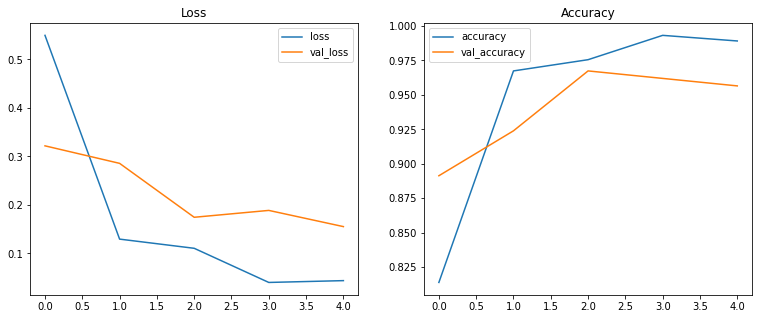

23/23 [==============================] - 2s 100ms/step - loss: 0.1552 - accuracy: 0.9565
[0.15516014397144318, 0.95652174949646]


In [38]:
############################
# Training Params
############################
learning_rate = 2e-5
epochs = 5

# Free up memory
K.clear_session()

# Build the model
model = build_pretrained_bert(num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate, epsilon=1e-08)
# Loss
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model, validation_data, training_results, execution_time, learning_rate, epochs)

### **Compare all Models**

In [39]:
models_store_path = "models"

models_metrics_list = glob(models_store_path+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

# Filter columns
view_metrics = view_metrics[["trainable_parameters","execution_time","loss",
                             "accuracy","model_size","learning_rate","epochs","name"]]
view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,epochs,name
0,"109,484,547",3.08 mins,0.16,95.65%,438 MB,0.00002,5,bert_pretrained_1616760488
3,"1,661,539",0.39 mins,0.53,91.30%,7 MB,0.01000,10,conv1d_emb_1616760431
2,"161,539",0.08 mins,0.59,90.76%,7 MB,0.01000,10,conv1d_pretrained_emb_1616760461
1,"104,427,363",0.17 mins,0.96,84.78%,418 MB,0.01000,10,simple_fcn_emb1616760413
4,"2,863,619",0.08 mins,1.02,52.72%,11 MB,0.01000,10,simple_fcn_1616760408


---

## **Text Generation using Language Models: GPT2** <div id='gpt2'>
---

### **Overview** <div id='gpt2_overview'>

**Language Model**: 

A model that understands language and how words appear in context to one another. The model is trained using unsupervised approaches such as next word prediction in a sentence or next sentence prediction.


**Comparing GPT2 with BERT**:

<table>
<tr><td width="400"><strong>GPT2</strong></td><td width="400"><strong>BERT</strong><td></tr>
<tr><td>Auto-regressive model (A word is predicted using words from its left context only)</td><td>Masked Language Model</td></tr>
<tr><td>Made up of only the Decoder with stacked transformer blocks</td><td>Made up of only the Encoder with stacked transformer blocks</td></tr>

<tr><td>Unidirectional language model</td><td>Bidirectional language model</td></tr>
<tr><td>Good for writing text</td><td>Good for fill in the blanks</td></tr>
</table>

<br>




**GPT-2** is a large transformer-based language model with 1.5 billion parameters, trained on a dataset of 8 million web pages. GPT-2 is trained with a simple objective: predict the next word, given all of the previous words within some text. The diversity of the dataset causes this simple goal to contain naturally occurring demonstrations of many tasks across diverse domains.

### **GPT2 Pretrained Lanaguage Model** <div id='gpt2_pretrained'>

#### **Tokenizer for GPT2**

In [40]:
# Tokenizer - Load the tokenizer specific to gpt2 training
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

#### **Load GPT2 Pretrained Model**

In [41]:
# Model - Load pretrained GPT Language Model
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


#### **Understand GPT2 Model Output**

In [42]:
print(model.config)

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.4.1",
  "use_cache": true,
  "vocab_size": 50257
}



In [43]:
# Input text
input_text = "How to make ice cream"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')
print("input_ids",input_ids)

model_outputs = model(input_ids=input_ids)
print(type(model_outputs))
# Reference for TFCausalLMOutputWithPast: https://huggingface.co/transformers/main_classes/output.html
# loss: Optional[tf.Tensor]
# logits: tf.Tensor => (batch_size, sequence_length, config.vocab_size)
# past_key_values: Optional[List[tf.Tensor]]
# hidden_states: Optional[Tuple[tf.Tensor]]
# attentions: Optional[Tuple[tf.Tensor]]

# Get the logits from output
logits = model_outputs.logits
print("logits.shape:",logits.shape)
print("logits:",logits)

# Get the last predicted token logits
next_token_logits = logits[:, -1, :].numpy()
next_token_logits = next_token_logits[0]
next_token_probs = tf.nn.softmax(next_token_logits).numpy()
print("next_token_logits.shape:",next_token_logits.shape)
print("next_token_logits:",next_token_logits)
print("next_token_probs:",next_token_probs)

input_ids tf.Tensor([[2437  284  787 4771 8566]], shape=(1, 5), dtype=int32)
<class 'transformers.modeling_tf_outputs.TFCausalLMOutputWithPast'>
logits.shape: (1, 5, 50257)
logits: tf.Tensor(
[[[ -34.018307  -33.696945  -37.407646 ...  -41.297718  -40.304005
    -33.973164]
  [-126.08545  -125.78109  -130.03444  ... -131.88132  -133.75713
   -125.15636 ]
  [ -86.445984  -86.96768   -91.71701  ...  -90.98091   -95.10483
    -86.84499 ]
  [ -81.66431   -83.30806   -86.07782  ...  -91.175766  -91.10269
    -84.193954]
  [-101.158966 -103.60024  -109.770035 ... -111.63823  -113.98953
   -103.066246]]], shape=(1, 5, 50257), dtype=float32)
next_token_logits.shape: (50257,)
next_token_logits: [-101.158966 -103.60024  -109.770035 ... -111.63823  -113.98953
 -103.066246]
next_token_probs: [7.5792102e-03 6.5976765e-04 1.3800167e-06 ... 2.1307757e-07 2.0294568e-08
 1.1253894e-03]


In [44]:
next_token = np.argmax(next_token_logits, axis=-1)
print(next_token,":",tokenizer.decode([next_token]))

351 :  with


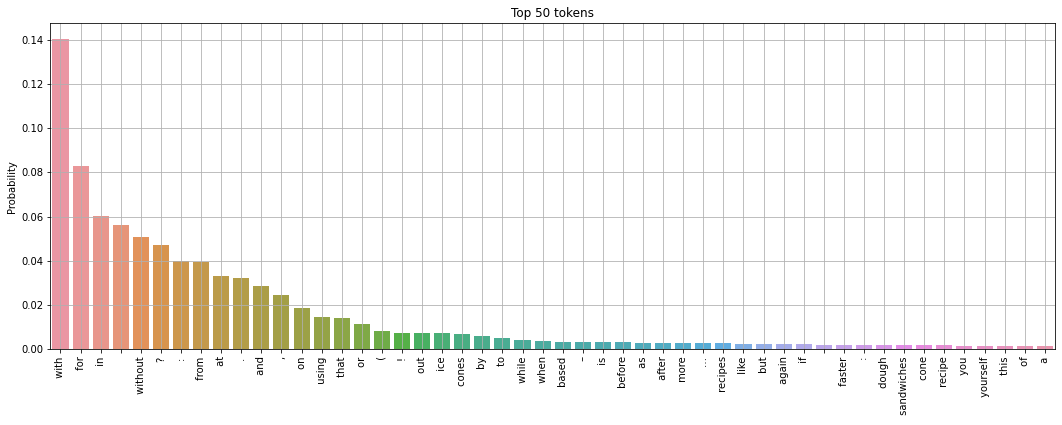

In [45]:
logits_idx = np.argsort(-next_token_logits, axis=-1)
# Pick the top n tokens
top_n = 50
top_idx = logits_idx[:top_n]
top_logits = next_token_logits[top_idx]
top_probs = next_token_probs[top_idx]
top_tokens = [tokenizer.decode([token]) for token in top_idx]

# print(len(top_idx),top_idx)
# print(len(top_logits),top_logits)
# print(len(top_tokens),top_tokens)

# Plot top logits
plt.subplots(figsize=(18,6))
ax = sns.barplot(x=top_tokens, y=top_probs, ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("Top {0} tokens".format(top_n))
plt.ylabel('Probability')

plt.show()

#### **Generate Text**

There are two ways GPT2 can generate text:
* Generate unconditional text: We start with <|endoftext|> which is a special start token to have the model generate words on its own.
* Generating conditional text: We provide a starting prompt and then GPT2 continues generatting text on that topic.

There are also diferent methods on how words are picked when generating text:
* Greedy search
* Beam search
* Top k sampling
* Top p sampling

<img src="https://storage.googleapis.com/public_colab_images/nlp/gpt2/laguage_generation_methods.svg"/>

##### Greedy Search

Greedy search will simply select the word with the highest probability as its next word: $w_t = argmax_{w}P(w | w_{1:t-1})$ at each timestep $t$. 

In [46]:
# Input text
input_text = "How to make ice cream"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')
print("input_ids",input_ids)

# max_length is the maximum length of the whole text, including input words and generated ones.
outputs = model.generate(input_ids, max_length=50,num_return_sequences=1)

print("Generated text:")
display(tokenizer.decode(outputs[0], skip_special_tokens=True))

input_ids tf.Tensor([[2437  284  787 4771 8566]], shape=(1, 5), dtype=int32)
Generated text:


'How to make ice cream with ice cream?\n\nThe answer is simple: make ice cream with ice cream.\n\nThe ice cream is made with ice cream.\n\nThe ice cream is made with ice cream.\n\nThe ice cream'

##### Beam Search

Beam search is an improved version of greedy search. It has a hyperparameter named beam size, $k$ . At time step 1, we select to $k$ tokens with the highest conditional probabilities. Each of them will be the first token of $k$ candidate output sequences, respectively. At each subsequent time step, based on the $k$ candidate output sequences at the previous time step, we continue to select $k$ candidate output sequences with the highest conditional probabilities.

In [47]:
# Input text
input_text = "How to make ice cream"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')
print("input_ids",input_ids)

# Generate output
outputs = model.generate(
    input_ids,  
    max_length=50, 
    num_beams=3, 
    early_stopping=False
)

print("Generated text:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

input_ids tf.Tensor([[2437  284  787 4771 8566]], shape=(1, 5), dtype=int32)
Generated text:
How to make ice cream with ice cream?

You can make ice cream with ice cream.

You can make ice cream with ice cream.

You can make ice cream with ice cream.

You can make ice cream with


##### Top k Sampling

In [48]:
# Input text
input_text = "How to make ice cream"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')
print("input_ids",input_ids)

# Generate output
outputs = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=30, 
    top_k=50
)

print("Generated text:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

input_ids tf.Tensor([[2437  284  787 4771 8566]], shape=(1, 5), dtype=int32)
Generated text:
How to make ice cream and other snacks.

5. How to make candy, other sweets, and snack-to-go items.



##### Top p Sampling

In [49]:
# Input text
input_text = "How to make ice cream"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')
print("input_ids",input_ids)

# Generate output
outputs = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=75, 
    top_p=0.80, 
    top_k=0
)

print("Generated text:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

input_ids tf.Tensor([[2437  284  787 4771 8566]], shape=(1, 5), dtype=int32)
Generated text:
How to make ice cream on the ice, doesn't it?

Not really. I think it's probably better if we just melt it with ice cream, and we'll find something to take out of it.

But it's always best to start off by melting it with ice cream.

What happens when you pour it over the ice?




---

### **<font color='red'>Break Out Room</font> 🎊🎉** <div id='gpt2_breakout'>

For this break out room go to this [notebook](https://colab.research.google.com/drive/1vaGR49GAEo6td-dNba5O1R3Fo4jqA65p?usp=sharing) and have fun writing text 😁 

---

### **Finetune GPT-2 Lanaguage Model** <div id='gpt2_finetune'>

In this section, we're going to be working with news articles from CNN related to covid-19. We will explore the dataset, prepare the data for finetuning GPT2.

**The Task:** Finetune GPT2 to build a language model on news articles related to health, specifically covid-19 related articles.

#### **Download Dataset**

Download the datasets to colab.

In [50]:
start_time = time.time()
# Dowload the news about covid dataset
download_file("https://storage.googleapis.com/cs109b/datasets/covid.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.013502029577891032


#### **Load Data**

* Read-in data as lists.

In [51]:
data_dir = os.path.join("datasets","covid")

# Load all the paths to text files
training_data = []
text_files = os.listdir(data_dir)
training_data.extend([os.path.join(data_dir,f) for f in text_files])

# Subset your training data for demo, full datset can take a long time to train
subset_data = True
if subset_data:
  training_data = training_data[:300]

# Load the text content
for idx, path in enumerate(training_data):
  # Load text
  with open(path) as file:
    training_data[idx] = file.read()

print("training_data count:",len(training_data))

training_data count: 300


#### **View Text**

Let's take a look at the data.

In [52]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(training_data)-1, size=10)
for i,data_idx in enumerate(data_samples):
  print("Text:",training_data[data_idx])

Text: Air quality in US dramatically worse than in prior years, says new 'State of the Air' report  (CNN)The air quality in the United States is dramatically declining, leaving about 150 million people -- nearly half of America's population -- breathing unhealthy, heavily polluted air, according to the newly released "State of the Air" 2020 report by the American Lung Association. "We're moving in the wrong direction, with nearly nine million more people breathing dirty air than in last year's report," said Paul Billings, the national senior vice president of public policy for the American Lung Association. That's particularly bad news for people like Tim Seib, a 37-year-old New York City regional theater director who has suffered from asthma his entire life.  "Knowing we've let our air get worse is maddening to me because air quality directly affects my day to day health," Seib said. "It's not a political stance, it's not an ideology thing." "When asthma symptoms start, you don't know

#### **Tokenize data for GPT2**

We will use the `distilgpt2` version of pre trained GPT2 model to tokenize text

In [53]:
# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

# Tokenize data
training_data_tokenized = []
for data in training_data:
  tokenized_text = tokenizer.encode(data)
  training_data_tokenized.append(tokenized_text)

print(len(training_data_tokenized))
print(len(training_data_tokenized[0]),training_data_tokenized[0][:20])

Token indices sequence length is longer than the specified maximum sequence length for this model (1862 > 1024). Running this sequence through the model will result in indexing errors



300
549 [47667, 12319, 20409, 3015, 284, 4313, 38477, 7509, 14, 42787, 11251, 3055, 39751, 312, 12, 1129, 12319, 287, 262, 1578]


#### **Generate Training Data**

For the training we need inputs and lables but we only have news article texts. In lecture we learnt that language models are trained in a smei supervised way where we generate inputs and labels from the input text. 

<br>

To generate inputs and lables for training we will chunk the input text into blocks of size `100`. Then our labels will be the same as inputs but one position shifted to the right.

In [54]:
# Split into blocks
training_chunks = []
block_size = 100
for tokenized_text in training_data_tokenized:
  for i in range(0, len(tokenized_text) - block_size + 1, block_size):  # Truncate in block of block_size
      training_chunks.append(tokenized_text[i:i + block_size])

# Generate inputs and labels
inputs = []
labels = []
for ex in training_chunks:
    inputs.append(ex[:-1])
    labels.append(ex[1:])

print("inputs length:",len(inputs))
print("labels length:",len(labels))

inputs length: 3934
labels length: 3934


In [55]:
print("input:",len(inputs[0]),inputs[0][:20])
print("labels:",len(labels[0]),labels[0][:20])

input: 99 [47667, 12319, 20409, 3015, 284, 4313, 38477, 7509, 14, 42787, 11251, 3055, 39751, 312, 12, 1129, 12319, 287, 262, 1578]
labels: 99 [12319, 20409, 3015, 284, 4313, 38477, 7509, 14, 42787, 11251, 3055, 39751, 312, 12, 1129, 12319, 287, 262, 1578, 1829]


In [56]:
BATCH_SIZE = 12
TRAIN_SHUFFLE_BUFFER_SIZE = len(inputs)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((inputs, labels))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE, drop_remainder=True)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)

train_data <PrefetchDataset shapes: ((12, 99), (12, 99)), types: (tf.int32, tf.int32)>


#### **Train/Finetune GPT2 Pretrained Model**

In [57]:
############################
# Training Params
############################
learning_rate = 3e-5 
epsilon=1e-08
clipnorm=1.0
epochs = 30

# Free up memory
K.clear_session()

# Build the model
model = TFGPT2LMHeadModel.from_pretrained("distilgpt2")

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon, clipnorm=clipnorm)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile
model.compile(loss=[loss, *[None] * model.config.n_layer],
                  optimizer=optimizer,
                  metrics=[metric])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data, # train_data.take(1000) for testing
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  81912576  
Total params: 81,912,576
Trainable params: 81,912,576
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
327/327 [==============================] - 83s 230ms/step - loss: 3.6690 - logits_loss: 3.6690 - logits_accuracy: 0.3241 - past_key_values_1_accuracy: 0.0015 - past_key_values_2_accuracy: 0.0013 - past_key_values_3_accuracy: 0.0025 - past_key_values_4_accuracy: 0.0017 - past_key_values_5_accuracy: 0.0012 - past_key_values_6_accuracy: 0.0013
Epoch 2/30
327/327 [==============================] - 75s 229ms/step - loss: 3.3414 - logits_loss: 3.3414 - logits_accuracy: 0.3535 - past_key_values_1_accuracy: 0.0015 - past_key_values_2_accuracy: 0.0013 - past_key_values_3_accuracy: 0.0025 - past_key_values_4_accura

#### **Generate Text**

In [58]:
# Input text
input_text = "how is covid affecting"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')
print("input_ids",input_ids)

# Generate outout
outputs = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=75, 
    top_p=0.80, 
    top_k=0
)

print("Generated text:")
display(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


input_ids tf.Tensor([[ 4919   318 39849   312 13891]], shape=(1, 5), dtype=int32)
Generated text:


'how is covid affecting the whole country?  Dr. Ashish Jha, assistant professor of preventive medicine at Harvard Medical School, answered that there is no question about that. "The idea that it\'s like some kind of blanket immunity is something that we don\'t really understand. The idea that it affects the whole country is completely ridiculous. I think we need to look'

In [59]:
# Input text
input_text = "the global pandemic"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')

# Generate outout
outputs = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=75, 
    top_p=0.80, 
    top_k=0
)

print("Generated text:")
display(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Generated text:


'the global pandemic, and how that impacts women\'s health and lives," she said.  The views expressed in this commentary are solely those of the writers. CNN is showcasing the work of The Conversation, a collaboration between journalists and academics to provide news analysis and commentary. The content is produced solely by The Conversation.  (CNN)It\'s the fall surge that has thrown'

---

## **Word2Vec Embeddings** <div id='word2vec'>
---

#### **Overview** <div id='word2vec_overview'>

If you recall from [Lecture 23: Language Representations](https://edstem.org/us/courses/3773/lessons/11929/slides/57591) Word2Vec was a breakthough for language representations:
<br>
<img src="https://storage.googleapis.com/public_colab_images/nlp/word2vec_lecture.png" width="600px"/>

There are two approaches to train a Word2Vec model:
* Continuous bag-of-words (CBOW)
* SkipGram (w/ Negative Sampling)

We will implement the SkipGram (w/ Negative Sampling) in this section. 

<br>

But before we start why do we need embeddings? These are some of the take aways from lecture and advanced section:
* One hot encoding text will bee too large (vocab size * vocab size)
* There is no relationship between workd tokens (no similarity between vectors)
* So what we need is a way for the word representation to have a semantic meaning and words that are semantically similar can be representted closer together in some dimension

#### **Preprocess Data** <div id='word2vec_data'>

We will use the same data from the previsous section

In [60]:
# We will use the same data from the previous section

# Get Word tokenizer & stop words from NLTK
stop_words = set(stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')

all_words = []
for data in training_data:
  # Word Tokenize text
  words = tokenizer.tokenize(data)
  # Remove stop words
  words = [w.lower() for w in words if w.lower() not in stop_words]
  all_words.extend(words)

# Vocab size
vocab_size = len(set(all_words))+1
print("vocab_size:",vocab_size)

print("all_words:",len(all_words))
print(all_words[:20])

vocab_size: 14348
all_words: 185648
['cdc', 'vaccine', 'advisers', 'vote', 'recommend', 'pfizer', 'biontech', 'covid', '19', 'vaccine', 'united', 'states', 'cnn', 'us', 'centers', 'disease', 'control', 'prevention', 'advisory', 'committee']


In [61]:
def build_dataset(words, vocab_size):
    """Process raw inputs into tokens"""

    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocab_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

# Tokenize input
all_words_tokens, counts, dictionary, reverse_dictionary = build_dataset(all_words, vocab_size)

print("all_words_tokens len:",len(all_words_tokens))
print(all_words_tokens[:5])

all_words_tokens len: 185648
[29, 6, 1434, 1212, 790]


In [62]:
counts[:20]

[['UNK', 0],
 ('said', 3214),
 ('people', 1746),
 ('covid', 1628),
 ('19', 1445),
 ('health', 1389),
 ('vaccine', 1193),
 ('coronavirus', 1126),
 ('cnn', 949),
 ('us', 930),
 ('new', 886),
 ('get', 813),
 ('cases', 813),
 ('one', 749),
 ('patients', 748),
 ('dr', 692),
 ('virus', 679),
 ('pandemic', 669),
 ('states', 659),
 ('also', 655)]

#### **Generate Training Data**

In [63]:
# Parameters for our skipgram with negative sampling 
window_size = 4

# We use the `skipgrams` function from tensorflow.keras
# to build the training dataset
couples, labels = keras.preprocessing.sequence.skipgrams(all_words_tokens, vocab_size, window_size=window_size)

# Split the couples to target and context
targets = []
contexts = []
for target_word, context_word in couples:
    targets.append(target_word)
    contexts.append(context_word)

print("couples",couples[:5])
print("labels",labels[:5])
print("targets",targets[:5])
print("contexts",contexts[:5])

couples [[5248, 10680], [1904, 7], [24, 150], [4224, 10], [91, 128]]
labels [1, 1, 0, 1, 1]
targets [5248, 1904, 24, 4224, 91]
contexts [10680, 7, 150, 10, 128]


In [64]:
BATCH_SIZE = 1024
TRAIN_SHUFFLE_BUFFER_SIZE = 10000

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)

train_data <PrefetchDataset shapes: (((None,), (None,)), (None,)), types: ((tf.int32, tf.int32), tf.int32)>


#### **Build Word2Vec Model** <div id='word2vec_model'>

We will utilize the model architecture from [Advanced Section 3 - Word Embedding](https://edstem.org/us/courses/3773/lessons/11576/slides/55277)
<img src="https://storage.googleapis.com/public_colab_images/nlp/gpt2/skip_gram_lm.png" width="800px"/>

In [65]:
def build_word2vec_model(vocab_size, vector_dim):
    
    # Build the target word embedding
    word_model = Sequential() 
    word_model.add(keras.layers.Embedding(vocab_size, vector_dim,input_length=1,name='embedding')) 
    word_model.add(keras.layers.Reshape((vector_dim, ))) 

    # Build the context word embedding
    context_model = Sequential() 
    context_model.add(keras.layers.Embedding(vocab_size, vector_dim, input_length=1,name='context')) 
    context_model.add(keras.layers.Reshape((vector_dim,))) 

    # Take the dot product of the the target and context word
    dot_product = keras.layers.dot([word_model.output, context_model.output], axes=1,
                                   normalize=False,name='dotproduct') 
    dot_product = keras.layers.Dense(1,activation="sigmoid")(dot_product) 

    # Complete word2vec model
    model = Model(inputs=[word_model.input, context_model.input],outputs=dot_product)
    
    return model

#### **Train Word2Vec Model** <div id='word2vec_train'>

In [66]:
learning_rate = 0.01 
epochs = 10
vector_dim = 128

# Free up memory
K.clear_session()

# Build the model
model = build_word2vec_model(vocab_size, vector_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.binary_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       1836544     embedding_input[0][0]            
__________________________________________________________________________________________________
context (Embedding)             (None, 1, 128)       1836544     context_input[0][0]              
______________________________________________________________________________________________

#### **Analyze Word2Vec Embeddings** <div id='word2vec_analyze'>

In [67]:
# Some util functions to analze embeddings

def find_similar_words(sample_words, num_similar, weights, dictionary, reverse_dictionary):
    embedding_clusters = []
    word_clusters = []
    for word in sample_words:
        similarities = cosine_similarity(weights, weights[dictionary[word]].reshape(1, -1))
        similar_words = [reverse_dictionary[x[0]] for x in np.argsort(similarities,axis=0)[-num_similar:]]
        similar_embeds = weights[np.argsort(similarities,axis=0)[-num_similar:].flatten()]
        embedding_clusters.append(similar_embeds)
        word_clusters.append(similar_words)

    return embedding_clusters, word_clusters


def tsne_plot_clusters(labels, embedding_clusters, word_clusters):
    "Creates and TSNE model and plots it"
    
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = manifold.TSNE(perplexity=25, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

    plt.figure(figsize=(20, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embeddings_en_2d, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=0.7, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                        textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.title('Clusters of similar words')
    plt.xlabel('TSNE Component1')
    plt.ylabel('TSNE Component2')
    plt.grid(True)
    plt.show()

In [68]:
# Get the embeddings
word2vec_embedding = model.get_layer('embedding').embeddings
print(word2vec_embedding.shape)
print(word2vec_embedding)

(14348, 128)
<tf.Variable 'embedding/embeddings:0' shape=(14348, 128) dtype=float32, numpy=
array([[-5.2486286e-03,  2.2191405e-03, -1.7072082e-02, ...,
        -5.3563230e-03,  2.3785267e-02,  4.8862945e-02],
       [ 9.1568090e-02,  2.1894306e-01,  1.3825548e-01, ...,
        -5.2436048e-01,  3.5581893e-01, -8.5585952e-01],
       [-1.1776851e+00, -1.0535727e+00, -4.9887386e-01, ...,
         1.0510033e+00, -4.9818400e-01,  1.0666715e+00],
       ...,
       [ 1.3994739e+00, -1.2325442e+00,  1.4402565e+00, ...,
        -6.8370402e-01,  1.2661200e+00,  5.7009107e-01],
       [ 2.3712916e+00,  8.4068382e-01, -3.7640205e-01, ...,
         2.6790719e+00,  1.2970321e-01,  6.0200638e-01],
       [ 5.4622149e-01, -1.3603698e+00,  4.3773198e-01, ...,
        -1.6251355e+00,  1.7934453e+00,  2.4059547e-01]], dtype=float32)>


In [69]:
# Get the embeddign layer weigths
embedding_layer_weights = word2vec_embedding.numpy()

word_list = ['pfizer','mask','flu','vaccine','smell']

for word in word_list:
    similar_embeddings, similar_labels = find_similar_words([word],5, 
                                                            embedding_layer_weights, dictionary, reverse_dictionary)

    print("Words similar to:",word,"\n",similar_labels)

Words similar to: pfizer 
 [['379', 'bureaucrats', 'moderna', 'biontech', 'pfizer']]
Words similar to: mask 
 [['disposable', 'layering', 'wearing', 'cinch', 'mask']]
Words similar to: flu 
 [['season', 'downright', 'zika', '155', 'flu']]
Words similar to: vaccine 
 [['hypersensitivity', 'pinning', 'novovax', 'unprofessional', 'vaccine']]
Words similar to: smell 
 [['aerosolization', 'kaya', 'pasta', 'taste', 'smell']]


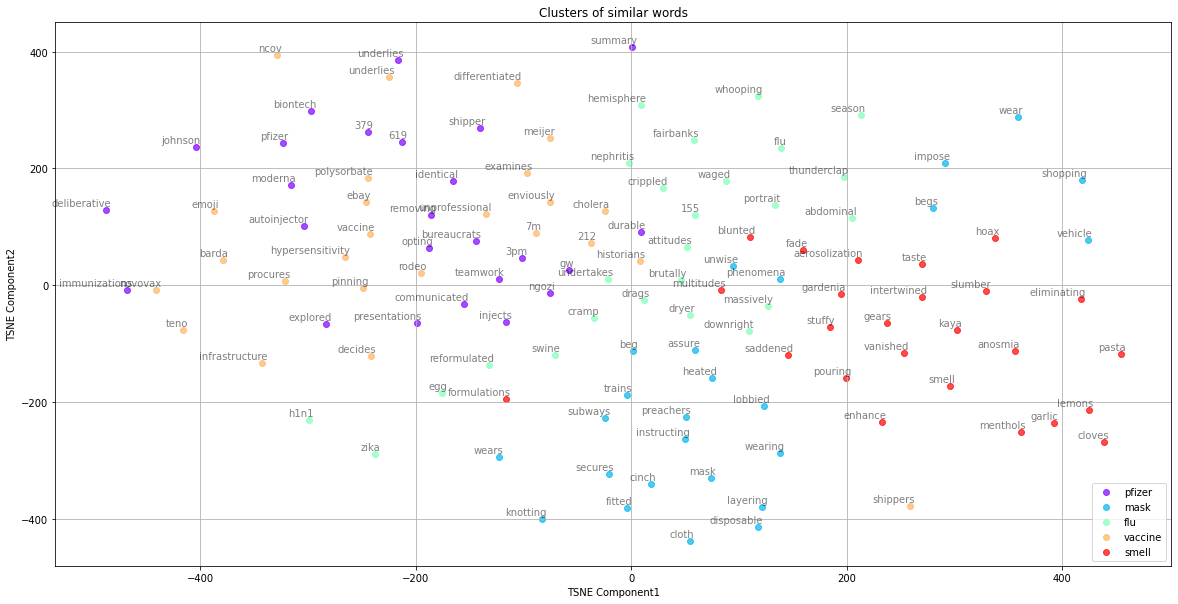

In [70]:
word_list = ['pfizer','mask','flu','vaccine','smell']
embedding_clusters, word_clusters = find_similar_words(word_list, 25, 
                                                       embedding_layer_weights, dictionary, reverse_dictionary)

tsne_plot_clusters(word_list, embedding_clusters, word_clusters)

---

## **References** <div id='references'>

### **Research Papers**
* [GPT (2018)](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)
* [GPT-2 (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
* [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)
* [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
* [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)

### **Code**

* [IACS ComputeFest 2021](https://github.com/Harvard-IACS/2021-ComputeFest/tree/main/Day2)
* [Transformer models](https://huggingface.co/transformers/model_summary.html)
* [Transformers source code](https://github.com/huggingface/transformers/tree/master/src/transformers)
* [Text classification from scratch](https://keras.io/examples/nlp/text_classification_from_scratch/)
* [Using pre-trained word embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/)

### **Articles**

* [The Illustrated GPT-2](http://jalammar.github.io/illustrated-gpt2/)
* [Open AI: GPT-2](https://openai.com/blog/better-language-models/)
* [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
